In [1]:
import random
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as mp

In [2]:
                                        # Calculation functoins # 

def returns_calculation(P):
    returns = np.zeros(P.size-1)
    for _ in range(1, P.size):
        returns[_-1] = (P[_]/P[_-1])-1
    return returns

def STD_calculation(X):
    return np.std(X)

def random_common_week(P, period = 7):
    Prices = np.random.randint(mean_price * (1 - prices_range_ratio), mean_price * (1 + prices_range_ratio), size=period)
    return np.hstack((P[period:],Prices))

def random_week(sigma_event, P, period = 7):
    Prices = np.random.randint(mean_price * (1 - (sigma_event*prices_range_ratio)), mean_price * (1 + (sigma_event*prices_range_ratio)), size=period)
    return np.hstack((P[period:],Prices))

def daily_change(P, period = 1):
    Prices = np.random.randint(mean_price * (1 - (sigma_event*prices_range_ratio)), mean_price * (1 + (sigma_event*prices_range_ratio)), size=period)
    return np.hstack((P[period:], Prices))

def expected_Price(P, std):
    return (3*std -(P[-1]/P[-2])*P[-1])

def raw_formula(sigm, crash_sigm, CF_acc = 0, liq_rate=0):

    ###
    # This approach operates with returns
    # Hard liquidation (50 %)
    ###
    price_ratio = 10
    CF = (1-(2*(crash_sigm+liq_rate/100)+1)*sigm)
    Debt = CF*price_ratio
    liq_rate = 1+(liq_rate/100)
    #Upd_L = CF*(price_ratio*(1-(crash_sigm*sigm)))
    Liq = 0.5*Debt
    Liq_a2 = Liq/(price_ratio*(1-(crash_sigm*sigm)))
    Up = 1-(liq_rate*Liq_a2)
    Rest = Up*CF*(price_ratio*(1-(crash_sigm*sigm)))

    #print(" CF = {:.3f}, debt = {:.3f}, rest = {:.3f}".format(CF, Debt/2, Rest))
    
    
    # !!! comparison with accurate solution (not ready yet) !!! #
    
    #alternative = Up*CF_acc*(price_ratio*(1-(crash_sigm*sigm)))
    #print(" Alternative rest = {:.3f}".format(alternative))
    
    return CF

def CF_calculation(Prices, nsigma):
    # Accurate formula (need to revise)
    
    P_init = Prices[-1]
    P_nsgima = np.mean(Prices) - (nsigma * STD_calculation(Prices))
    CF = ((2 / P_init) - (1 / P_nsgima)) #* (2 / np.mean(Prices))
    #print("CF = {:.3f}".format(CF))
    return CF

def K(table):
    K = np.zeros(table.shape[0])
    for i in range(table.shape[0]):
        K[i] = np.sqrt(table[i])+(1/np.sqrt(table[i]))-2
    return K

def CF2_calculation(Rb_tokens, B_price, IR_size, TWAP_period, K_table, p):
    l = np.zeros(K_table.shape[0])
    C = IR_size/(TWAP_period*Rb_tokens*B_price)
    
    for i in range(K_table.shape[0]):
        l[i] = abs(K_table[i]-C)
    return p[np.argmin(l)]


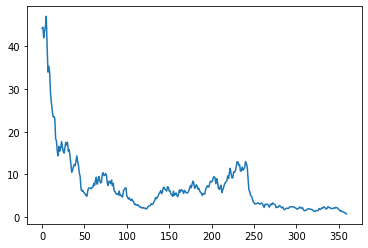

In [3]:
                                # Generating prices with M-K #

Test_period = 360
validation_period = 28
update_period = 5
sigma_event = 3
Max_CF = 0.9
absolute_percentage = 0.1
x_ax = np.arange(Test_period)

Title = "One-step M-K"


### M-K parameters
daily_vol = 0.1
last_adj_close_price = 42.056



### CF 2 assumptions ###
# Isolated Reserve and Pool Liquidity
IR_size = 10e6
Token_B_amount = 513
Token_B_price = 60
TWAP_period = 144


CF2_turn = 'off'


count = 0
price_list = []
last_price = last_adj_close_price

price = last_price * (1 + np.random.normal(0, daily_vol))
price_list.append(price)

for y in range(Test_period):
    if count == Test_period-1:
        break
    price = price_list[count]* (1 + np.random.normal(0, daily_vol))
    price_list.append(price)
    count += 1

mp.plot(price_list)
mp.show()

In [4]:

                                #################   Simulation    #################

p = np.arange(0.01,0.9,0.01)    
returns = returns_calculation(np.asarray(price_list)[-validation_period:])
std_returns = STD_calculation(returns)
# Res_acc = CF_calculation(lastN_prices[-28:]/(np.mean(lastN_prices)), sigma_event)
Res_raw = raw_formula(std_returns, 3)
K_table = K(p)
CF2_res = np.zeros(330) #Raw_g_const.shape[0]) # = CF2_calculation(Token_B_amount, Token_B_price, IR_size, TWAP_period, K_table, p)

# print(K_table)

# print("Right part of CF calc =",10e6/(144*513*1363))


Raw_plot = list()
Raw_plot_const = list()


for i in range((Test_period-validation_period)//update_period):
    Prices = np.asarray(price_list)[i*update_period:(i*update_period)+validation_period]

    returns = returns_calculation(Prices)#[-28:])
    std_returns = STD_calculation(returns)
    
    ###
    # expected_overPrice = expected_Price(Prices, std_returns)
    # percent_overPrice = np.abs(Prices[-1]-expected_overPrice)/Prices[-1]
    # Res_acc = CF_calculation(Prices[-28:] / (np.mean(Prices)), sigma_event)
    ###
    
    Res_raw = raw_formula(std_returns, sigma_event)
    if Res_raw > Max_CF:
        Res_raw = Max_CF
    
    Res_raw_const = Res_raw
    # absolute constraint #
    if Raw_plot_const != [] and Res_raw_const > (1+absolute_percentage)*Raw_plot_const[-1][-1]:
        Res_raw_const = (1+absolute_percentage)*Raw_plot_const[-1][-1]

    Raw_plot.append([Res_raw]*update_period)
    Raw_plot_const.append([Res_raw_const]*update_period)

Raw_g = np.zeros(len(Raw_plot)*len(Raw_plot[0]))
Raw_g_const = np.zeros(len(Raw_plot_const)*len(Raw_plot[0]))

m = 0
for j in range(len(Raw_plot)):
    for i in range(len(Raw_plot[0])):
        Raw_g[m] = Raw_plot[j][i]
        m+=1
m = 0
for j in range(len(Raw_plot_const)):
    for i in range(len(Raw_plot_const[0])):
        Raw_g_const[m] = Raw_plot_const[j][i]
        if Raw_g_const[m] < 0:
            Raw_g_const[m] = 0
        m+=1

        
# Discuss to update CF_2 calculation correctly
for v in range(0,Raw_g_const.shape[0], update_period):
    CF2_res[v:v+update_period] = [CF2_calculation(Token_B_amount, Token_B_price, IR_size, TWAP_period, K_table, p)]*update_period
    Token_B_amount = random.randint(400,600)       #####
    Token_B_price = random.randint(1200,1400) # Add from prices  #########


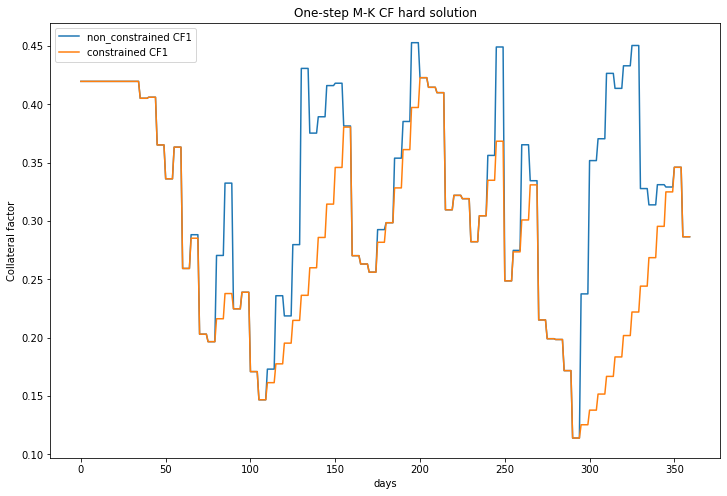

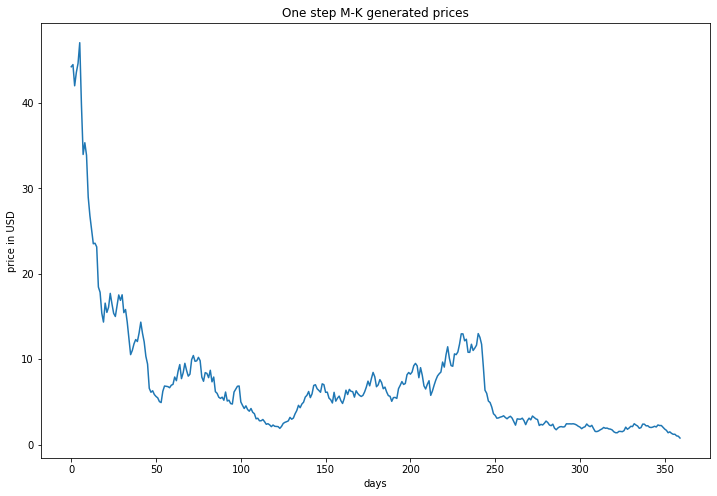

In [5]:
                                                    # CF curve #

#abs_const = np.load("Absolute_constraint.npy")
mp.rcParams['figure.figsize'] = [12, 8]
fig, ax = mp.subplots()
helped = np.full((Test_period - Raw_g.shape[0]), Raw_g[0])
showcase = np.zeros(Test_period - Raw_g.shape[0])
aave = [0.80]
#final_CF = np.zeros(CF2_res.shape[0])

# plot with validation period  
Non_constrained, = ax.plot(x_ax, np.hstack((helped, Raw_g)), label = "non_constrained CF1")
Constrained, = ax.plot(x_ax, np.hstack((helped, Raw_g_const)), label = "constrained CF1")
if CF2_turn == 'on':
    CF2_ex, = ax.plot(x_ax, np.hstack((helped, CF2_res)), label = "CF2")


#Non_constrained_showcase, = ax.plot(x_ax, np.hstack((showcase, Raw_g)), label = "non_constrained CF")
#Constrained_showcase = np.hstack((showcase, Raw_g_const))


# plot CF

mp.xlabel("days")
mp.ylabel("Collateral factor")
mp.title("{:.15s} CF hard solution".format(Title))
if CF2_turn == 'on':
    ax.legend(handles = [Non_constrained,Constrained, CF2_ex])
else:
    ax.legend(handles = [Non_constrained,Constrained])
mp.show()

# Plot generated prices

mp.xlabel("days")
mp.ylabel("price in USD")
mp.title("One step M-K generated prices")
mp.plot(price_list)
mp.show()

########################### After CF_2 discussion

# # final CF construction
# for i in range(CF2_res.shape[0]):
#     final_CF[i] = min(CF2_res[i],Raw_g[i])
#     if final_CF[i] < 0:
#         final_CF[i] = 0

# mp.plot(x_ax, np.hstack((helped, final_CF)))
# mp.xlabel("days")                                                                               # plot prices for comparison
# mp.ylabel("Collateral factor")
# mp.title("{:.15s} CF hard solution". format(Title))
# mp.show()